# MF6. Relación entre niveles medidos y calculados
* Régimen estacionario
* DISV grid

In [1]:
# This is because I was changing mf_plots.py as I was working here
%load_ext autoreload
%autoreload 2

In [2]:
import flopy.mf6 as mf6
import flopy.utils.binaryfile as bf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

In [4]:
# import mf_plots.py located in the same directory
import os
current_dir = os.getcwd()
os.environ['PYTHONPATH'] = current_dir
import mf_plots

## Lectura del fichero con los niveles medidos en puntos de observación
* Todos los sondeos están dentro del dominio del modelo.
* En este caso los tengo guardados en un fichero csv. 

In [6]:
# path to data file
fpath = r'E:\Cursos\H2OGEO\2023_Modelacion_HGeo\Ej_2\Niveles\_niveles_epsg25831_in_domain.csv'
df = pd.read_csv(fpath) 
df.head()

,sondeo,x,y,z,cnp,pnp,prof,campanya,anyo_lectura,observacio
0,SM1,432119.530805,4.591804e+06,30.309,21.809,8.5,25.0,< 2001,1999,NaN
1,SM3,432140.914559,4.591997e+06,30.465,22.965,7.5,23.0,< 2001,2005,NaN
2,SM5,432166.579268,4.592210e+06,31.177,24.177,7.0,18.5,< 2001,1999,NaN
3,SM6,432189.567023,4.592317e+06,32.000,24.500,7.5,20.0,< 2001,1999,NaN
4,SM20,432094.682088,4.591598e+06,29.255,21.255,8.0,26.0,< 2001,1990,NaN


In [16]:
# Set the column_names
obs_id = 'sondeo' # Column of observation point identifiers
x = 'x'  # column of x coordinate (projected)
y = 'y'  # column of y coordinate (projected)
obs = 'cnp'  # column of observations

# Modflow: file and directory names
modelname = 'Moncada.nam'
model_ws = 'E:/Cursos/H2OGEO/2023_Modelacion_HGeo/Ej_2'
model_ws_path = Path(model_ws)

# Unots for labels
length_unit = 'm'
time_unit = 'day'

In [17]:
# gwf is instantiated and some basic features are shown
sim = mf6.MFSimulation.load(sim_name=modelname, exe_name='mf6', sim_ws=model_ws)

model_names = list(sim.model_names)
print('\nModel names in sim', model_names)

gwf = sim.get_model(model_names[0])

grid_type = gwf.modelgrid.grid_type
print('Type of grid:', grid_type)
    
disv = gwf.get_package('disv')
print('Number of layers:', disv.nlay)

tdis = sim.tdis
nper = tdis.nper.get_data()
print('Number of stress periods:', nper)    

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package gnc...
    loading package oc...
    loading package chd...
    loading package wel...
    loading package riv...
    loading package rch...
  loading solution package modflow...

Model names in sim ['modflow']
Type of grid: vertex
Number of layers: {internal}
(1)

Number of stress periods: 1


## Sondeos: h observada vs simulada; RMSE  

In [19]:
%%time

# get the cell id for each observation point in df
cells_ids =[gwf.modelgrid.intersect(row[x], row[y]) for index, row in df.iterrows()]

CPU times: total: 53.9 s
Wall time: 53.9 s


In [31]:
# Required names (change them if necessary:

# Default head name
headfile = model_ws_path.joinpath(modelname)
headfile = headfile.with_suffix('.bhd')
# layer where heads are to be read
nlayer = 0
# csv file where results are to be saved
fresults = './calibration/h_obs_vs_sim_disv_stationary.csv'

# create headfile object
headobj = bf.HeadFile(headfile)

# get all times
times = headobj.get_times()
if len(times) > 1:
    raise ValueError('This is not stationary model')

# get the heads in a stationary simmulation
h_sim = []
for time in times:
    head = headobj.get_data(totim=time)
    for cell_id in cells_ids:
        h_sim.append(head[0, 0, cell_id + nlayer])

df['sim'] = h_sim
df['er'] = df[obs] - df[sim]
mse = ((df['er'])**2).mean()
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse} {length_unit}')

result = df[[obs_id, obs, 'sim', 'er', x, y]]
result.to_csv(fresults, index=False)
result.head()

print(f'Results saved in {fresults}')

Root Mean Squared Error (RMSE): 2.5585012337191912 m
Results saved in ./calibration/h_obs_vs_sim_disv_stationary.csv


## Plot h medida versus calculada

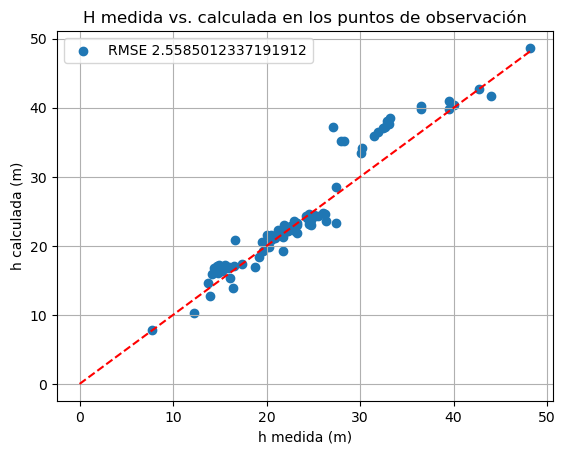

File saved in calibration\h_obs_vs_sim_disv_stationary.png


In [32]:
# png output file has the the same file name than fresults
foutput = Path(fresults).with_suffix('.png')
mf_plots.plot_h_obs_sim_sta(foutput, df[obs].to_numpy(), df['sim'].to_numpy(), rmse)
print(f'File saved in {foutput}')